# Movie Rating Prediction

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Data Preprocessing
- missing value
- duplicates
- data type
- outlier

In [2]:
raw = pd.read_csv('movie_metadata.csv')
raw.head(2)
raw.shape

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0


(5043, 28)

In [3]:
# check missing value
raw.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [4]:
# the remaining dataset is still in good shape and has enough instances
# besides, some categorical values are not estimatable
# so drop instances with missing value is feasible

df = raw.reindex(sorted(raw), axis =1).\
                dropna().\
                drop_duplicates() # drop duplicates

# convert inproper data types into appropriate ones
df['title_year'] = df['title_year'].astype(int)

In [5]:
# replace genres with prime genre
genre = df.genres.str.split('|').tolist()
prime_genre = [i[0] for i in genre]
# drop trivial variables in this project
df = df.drop(['genres','movie_imdb_link','movie_title', 'plot_keywords'], axis = 1)
df['prime_genre'] = prime_genre

df.head(2)
df.shape

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,aspect_ratio,budget,cast_total_facebook_likes,color,...,facenumber_in_poster,gross,imdb_score,language,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,prime_genre
0,1000.0,CCH Pounder,936.0,Joel David Moore,855.0,Wes Studi,1.78,237000000.0,4834,Color,...,0.0,760505847.0,7.9,English,33000,723.0,3054.0,886204,2009,Action
1,40000.0,Johnny Depp,5000.0,Orlando Bloom,1000.0,Jack Davenport,2.35,300000000.0,48350,Color,...,0.0,309404152.0,7.1,English,0,302.0,1238.0,471220,2007,Action


(3723, 25)

In [6]:
# seperate catogorical and numerical variables
dtype_pairs = dict(df.dtypes).items()
obj_col = [key for key, value in dtype_pairs if value == 'object']
num_col = list(np.setdiff1d(df.columns, obj_col))
# seperate independent and dependent variables
X_col = [i for i in num_col if i != 'imdb_score']

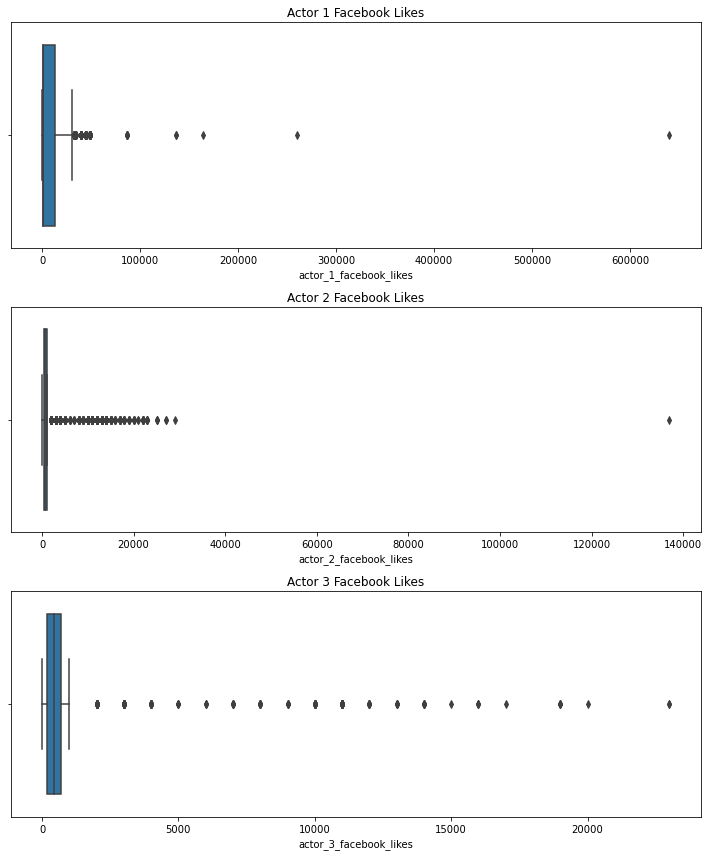

In [7]:
# univariate outlier
fig, axs = plt.subplots(3, 1, figsize = (10,12))
sns.boxplot(ax = axs[0], x = df['actor_1_facebook_likes'])
axs[0].set_title('Actor 1 Facebook Likes')
sns.boxplot(ax = axs[1], x = df['actor_2_facebook_likes'])
axs[1].set_title('Actor 2 Facebook Likes')
sns.boxplot(ax = axs[2], x = df['actor_3_facebook_likes'])
axs[2].set_title('Actor 3 Facebook Likes')
fig.tight_layout();

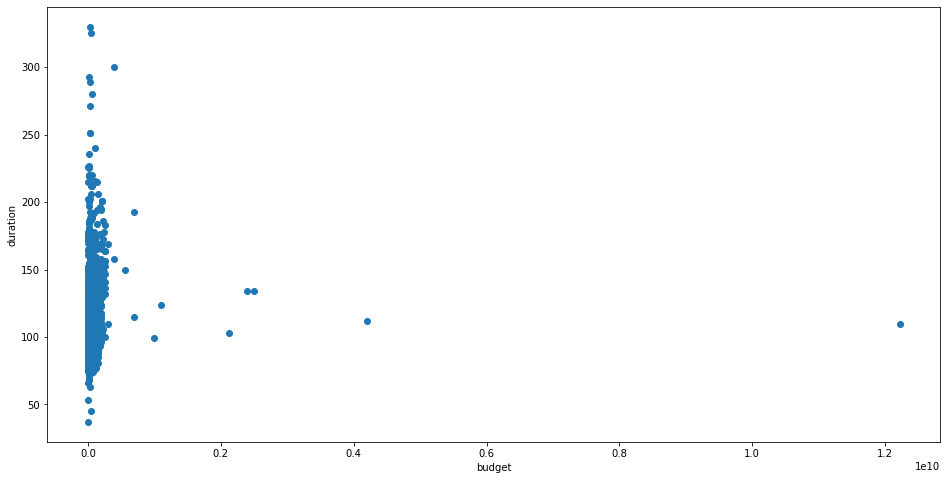

In [8]:
# multivariate outlier
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['budget'], df['duration'])
ax.set_xlabel('budget')
ax.set_ylabel('duration');

In [9]:
# replace outliers with the threshold value of IQR
def remove_outlier(col):
    sorted(col)
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

for col in X_col:
    lower_cap, upper_cap = remove_outlier(df[col])
    df[col] = np.where(df[col] > upper_cap, upper_cap, df[col])
    df[col] = np.where(df[col] < lower_cap, lower_cap, df[col])

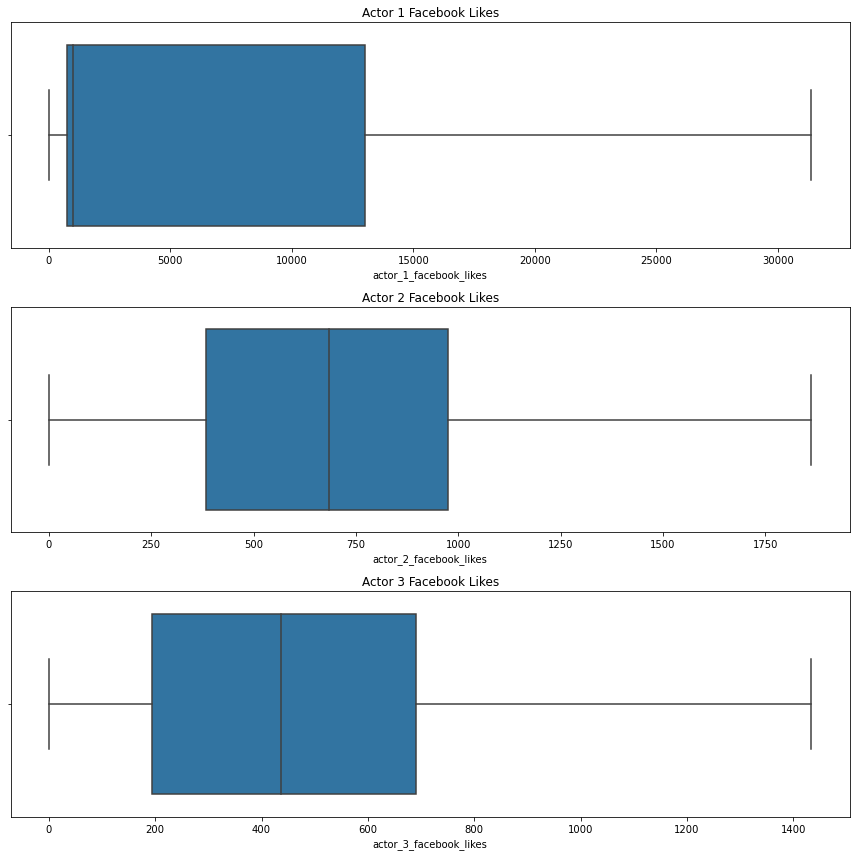

In [10]:
# boxplot after removing outlier
fig, axs = plt.subplots(3, 1, figsize = (12,12))
sns.boxplot(ax = axs[0], x = df['actor_1_facebook_likes'])
axs[0].set_title('Actor 1 Facebook Likes')
sns.boxplot(ax = axs[1], x = df['actor_2_facebook_likes'])
axs[1].set_title('Actor 2 Facebook Likes')
sns.boxplot(ax = axs[2], x = df['actor_3_facebook_likes'])
axs[2].set_title('Actor 3 Facebook Likes')
fig.tight_layout();

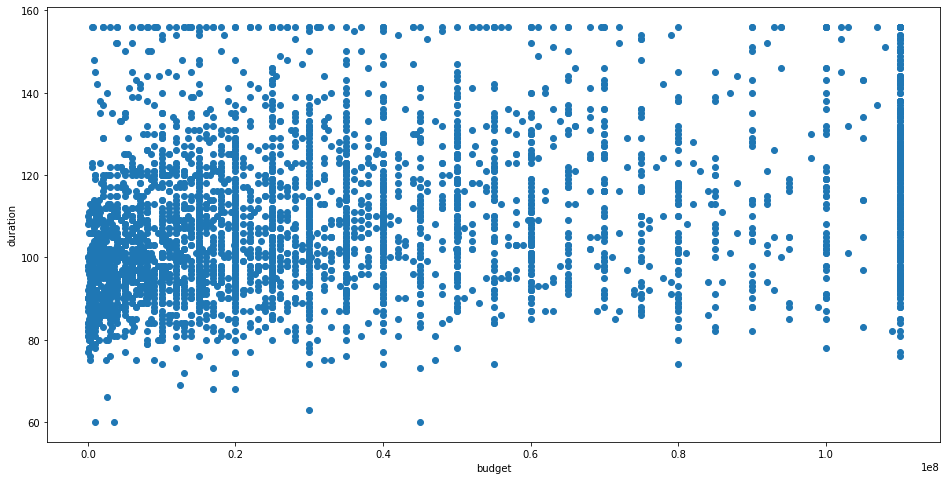

In [11]:
# scatter plot after removing outlier
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['budget'], df['duration'])
ax.set_xlabel('budget')
ax.set_ylabel('duration');

## EDA
- Correlation heatmap
- Univariate Analysis
- Bivariate Analysis

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
actor_1_facebook_likes,1.000000,0.591265,0.476559,0.154973,0.277126,0.952837,0.163037,0.207930,0.068632,0.241501,0.170062,0.251986,0.294180,0.256140,0.349127,0.149087
actor_2_facebook_likes,0.591265,1.000000,0.777627,0.131441,0.324209,0.739801,0.113045,0.171263,0.094402,0.315484,0.061792,0.220715,0.260891,0.244147,0.316702,0.165229
actor_3_facebook_likes,0.476559,0.777627,1.000000,0.105783,0.294207,0.623507,0.081095,0.148164,0.120070,0.309703,0.007877,0.191188,0.215195,0.221432,0.275670,0.134651
aspect_ratio,0.154973,0.131441,0.105783,1.000000,0.263339,0.151784,0.094795,0.247407,0.037884,0.112433,0.036449,0.166186,0.259454,0.171031,0.150613,0.259750
budget,0.277126,0.324209,0.294207,0.263339,1.000000,0.306108,0.166432,0.311800,-0.019443,0.622792,0.003890,0.232389,0.393938,0.400432,0.439751,0.226319


<AxesSubplot:>

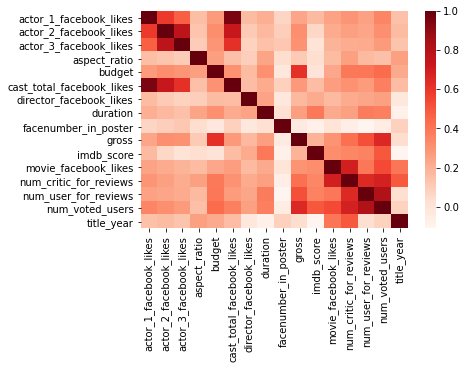

In [12]:
# correlation matrix and heatmap

# since the primary goal of this project is to predict, not interpret the coefficients
# which are severely influenced by multicollinearity, it is okay to leave those
# variables with high correlation
corr = df.corr()
corr.head()
sns.heatmap(corr, cmap = 'Reds')

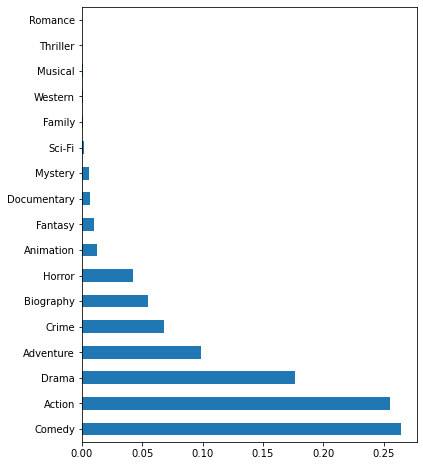

In [13]:
# prime genre in barplot
genres = df['prime_genre'].value_counts(normalize = True)
genres.plot.barh(figsize = (6, 8));

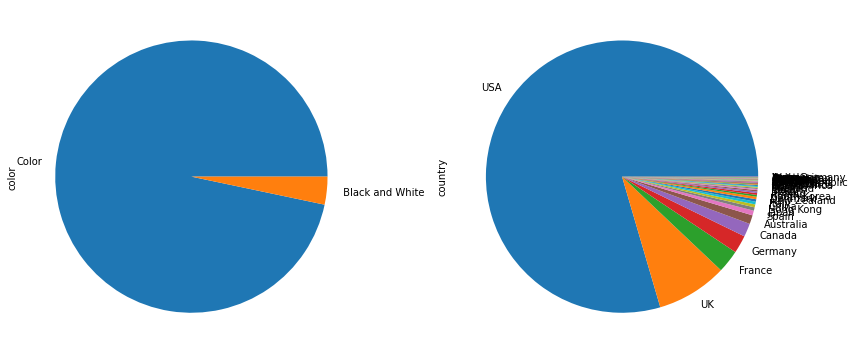

In [14]:
# country in pie chart
fig, axs = plt.subplots(1, 2, figsize = (12,12))
color = df['color'].value_counts()
color.plot.pie(ax = axs[0])
country = df['country'].value_counts()
country.plot.pie(ax = axs[1])
fig.tight_layout();

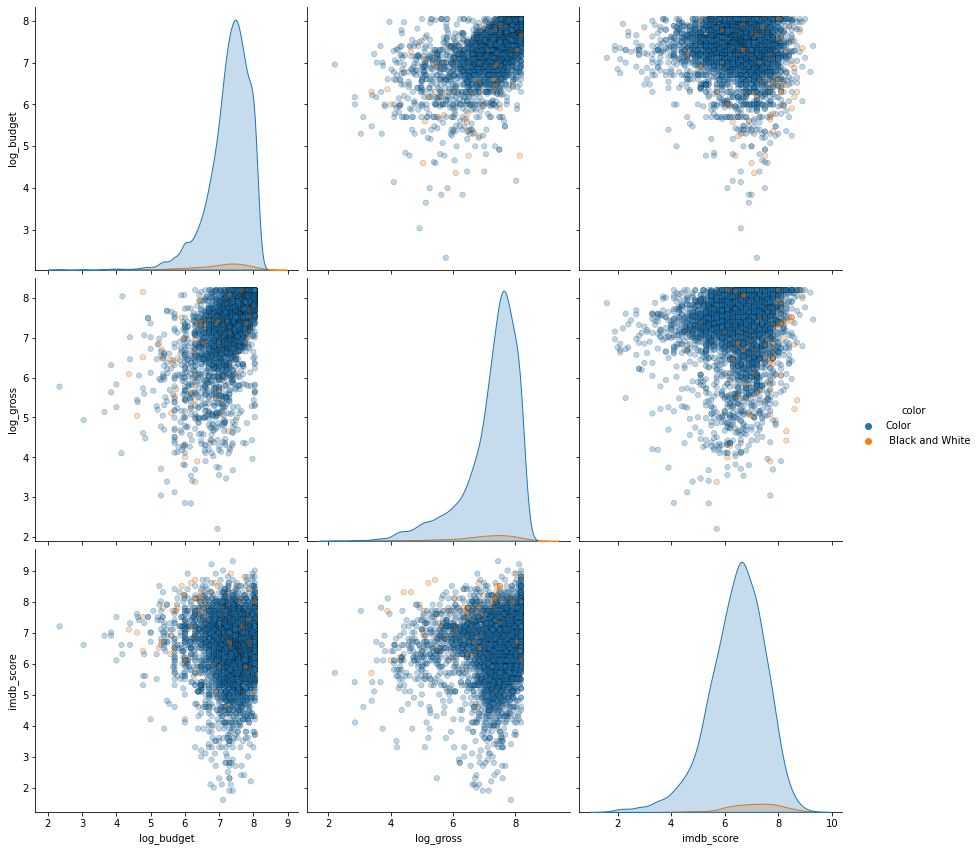

In [15]:
df['log_budget'] = np.log10(df['budget'])
df['log_gross'] = np.log10(df['gross'])

# pair plot
sns.pairplot(df, 
             vars = ['log_budget', 'log_gross', 'imdb_score'], 
             hue = 'color', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.3, 's': 30, 'edgecolor': 'k'},
             height = 4);

## Standardization 

In [16]:
# in order to prevent the future modeling being dominated by certain large-scale variables,
# it is necessary to perform standardization
df.describe().transpose()
# standardize only the numerical independent variables
df = df.drop(['log_budget', 'log_gross'], axis = 1)
df[X_col] = StandardScaler().fit_transform(df[X_col])
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
actor_1_facebook_likes,3723.0,7.065179e+03,8.725394e+03,0.000000,7.445000e+02,1.000000e+03,1.300000e+04,3.138325e+04
actor_2_facebook_likes,3723.0,7.788663e+02,5.497059e+02,0.000000,3.835000e+02,6.830000e+02,9.750000e+02,1.862250e+03
actor_3_facebook_likes,3723.0,4.790790e+02,3.504481e+02,0.000000,1.940000e+02,4.360000e+02,6.900000e+02,1.434000e+03
aspect_ratio,3723.0,2.107217e+00,2.713871e-01,1.180000,1.850000e+00,2.350000e+00,2.350000e+00,3.100000e+00
budget,3723.0,3.537880e+07,3.248596e+07,218.000000,1.000000e+07,2.500000e+07,5.000000e+07,1.100000e+08
cast_total_facebook_likes,3723.0,1.022899e+04,1.134160e+04,0.000000,1.907000e+03,4.050000e+03,1.623250e+04,3.772075e+04
director_facebook_likes,3723.0,1.560870e+02,1.935729e+02,0.000000,1.100000e+01,6.300000e+01,2.350000e+02,5.710000e+02
duration,3723.0,1.092036e+02,1.841691e+01,60.000000,9.600000e+01,1.060000e+02,1.200000e+02,1.560000e+02
facenumber_in_poster,3723.0,1.249261e+00,1.476002e+00,0.000000,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
gross,3723.0,4.578178e+07,4.709269e+07,162.000000,8.124330e+06,3.005003e+07,6.690181e+07,1.550680e+08


,count,mean,std,min,25%,50%,75%,max
actor_1_facebook_likes,3723.0,-1.526818e-17,1.000134,-0.809835,-0.724498,-0.695212,0.680269,2.787420
actor_2_facebook_likes,3723.0,0.000000e+00,1.000134,-1.417068,-0.719329,-0.174419,0.356845,1.971107
actor_3_facebook_likes,3723.0,-9.160906e-17,1.000134,-1.367231,-0.813579,-0.122942,0.601942,2.725223
aspect_ratio,3723.0,-1.771108e-15,1.000134,-3.417045,-0.947915,0.894720,0.894720,3.658671
budget,3723.0,1.221454e-16,1.000134,-1.089188,-0.781328,-0.319528,0.450138,2.297338
cast_total_facebook_likes,3723.0,6.107270e-17,1.000134,-0.902021,-0.733856,-0.544881,0.529407,2.424301
director_facebook_likes,3723.0,-8.397497e-17,1.000134,-0.806456,-0.749622,-0.480953,0.407720,2.143733
duration,3723.0,-1.221454e-16,1.000134,-2.672012,-0.717024,-0.173972,0.586301,2.541289
facenumber_in_poster,3723.0,4.389601e-17,1.000134,-0.846495,-0.846495,-0.168899,0.508698,2.541488
gross,3723.0,9.160906e-17,1.000134,-0.972290,-0.799753,-0.334104,0.448538,2.320975


## Categorical Encoding

In [17]:
# labeling categorical variables

# unique values in each categorical variables
obj_dict = {obj_col[i] : len(df[obj_col[i]].unique()) for i in range(len(obj_col))}
obj_dict

# considering the large unique value counts in categorical variables
# it is more reasonable to use label encoding instead of one-hot encoding
for col in obj_col:
    df[col] = LabelEncoder().fit_transform(df[col])

df.head(2)

{'actor_1_name': 1428,
 'actor_2_name': 2188,
 'actor_3_name': 2587,
 'color': 2,
 'content_rating': 12,
 'country': 45,
 'director_name': 1659,
 'language': 34,
 'prime_genre': 17}

,actor_1_facebook_likes,actor_1_name,actor_2_facebook_likes,actor_2_name,actor_3_facebook_likes,actor_3_name,aspect_ratio,budget,cast_total_facebook_likes,color,...,facenumber_in_poster,gross,imdb_score,language,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year,prime_genre
0,-0.695212,189,0.285889,1002,1.072831,2529,-1.205884,2.297338,-0.475745,1,...,-0.846495,2.320975,7.9,9,2.197089,2.511931,2.276928,2.27594,0.677794,0
1,2.787420,687,1.971107,1592,1.486643,1001,0.894720,2.297338,2.424301,1,...,-0.846495,2.320975,7.1,9,-0.616217,1.238691,2.276928,2.27594,0.435523,0


## Split data

In [18]:
# trainset and testset
df_train = df.sample(frac = 0.8, random_state = 1)
df_test = df.drop(df_train.index)

# independent and dependent variables
train_x = df_train.copy()
test_x = df_test.copy()
train_y = df_train.pop('imdb_score')
test_y = df_test.pop('imdb_score')

## Modeling
- one multivariate linear model
- two DNN models

In [19]:
# build normalization layer
normalizer = preprocessing.Normalization()

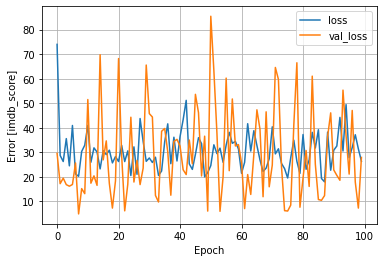

In [20]:
# linear model
# build and compile model in sequence
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)])

linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error')

# fit model
history = linear_model.fit(
    train_x, train_y,
    epochs = 100, verbose = 0,
    validation_split = 0.2)

# visualization of training process
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [imdb_score]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# evaluate model
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_x, test_y, verbose=0)

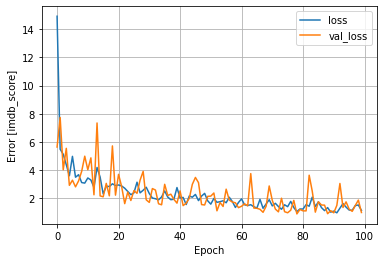

In [21]:
# DNN model applying rectified linear unit activation function and Adam algorithm optimizer
# add neuron layers besides normalization layer
def model_1(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model_1 = model_1(normalizer)

history = dnn_model_1.fit(
    train_x, train_y,
    verbose=0, epochs=100,
    validation_split=0.2)

plot_loss(history)

test_results['dnn_model_1'] = dnn_model_1.evaluate(test_x, test_y, verbose=0)

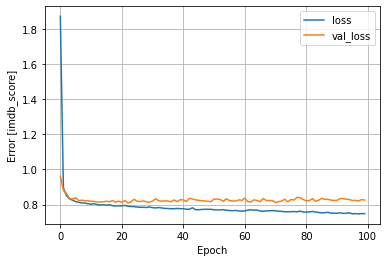

In [22]:
# DNN model applying Hyperbolic tangent activation function and Adamax algorithm optimizer
def model_2(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='tanh'),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adamax(0.001))
    return model

dnn_model_2 = model_2(normalizer)

history = dnn_model_2.fit(
    train_x, train_y,
    verbose=0, epochs=100,
    validation_split=0.2)

plot_loss(history)

test_results['dnn_model_2'] = dnn_model_2.evaluate(test_x, test_y, verbose=0)

In [23]:
# performance comparison
pd.DataFrame(test_results, index = ['Mean absolute error (imdb_score)']).transpose()

,Mean absolute error (imdb_score)
linear_model,29.511837
dnn_model_1,0.966076
dnn_model_2,0.846006
